**Classification**

This notebook is inspired from the handson-ml2 GitHub repository by Aurélien Geron

https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Utility functions

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# MNIST

In [3]:
# Download MNIST Data
# Setting version as 1 as there might be many versions of mnist_784 dataset
# https://www.openml.org/d/554

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [4]:
# Print the keys

# A DESCR key describing the dataset
# A data key containing an array with one row per instance and one column per feature
# A target key containing an array with the labels

mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
# Getting data and label
# X --> data
# y --> label

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

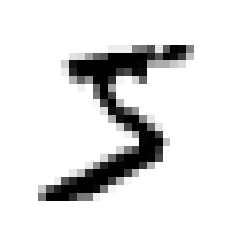

In [7]:
# Lets check the data
# Plot the first digit

some_digit = X[0]
some_digit_image1 = plot_digit(some_digit)

In [8]:
# Lets see the correspnding label

y[0]

'5'

In [9]:
# Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [10]:
# Lets split the data into training and test with 60,000 images in training set and rest 10000 in test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier - Train 5-detector

In [11]:
# Preparaing Training and Test set for 5-detector

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5) # True for all 5s, False for all other digits

In [12]:
# Let's train the model
# We will use Stochastic Gradient Descent(SGD) classifier
# This classifier has the advantage of being capable of handling very large datasets efficiently

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
# Lets see the prediction

sgd_clf.predict([some_digit])

array([ True])

# Performance Measures 

## Measuring Accuracy Using Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# Build a dumb classifier that just classifies every single image in the “not-5” class

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [17]:
# Get the predicted values

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
# Confusion matrix of 5-detector

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [19]:
# Get Precision Score of 5-detector

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
# Get Recall Score of 5-detector

recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
# Get f1 score of 5-detector

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Tradeoff

In [22]:
# Get Decision score of some_digit which is 5

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
# Change threshold to 0 and see the prediction

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# Change threshold to 8000 and see the prediciton

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Plot Precision/Recall Curve

In [25]:
# Get the scores of all the training dataset using cross_val_predict with decision_function as function

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
# Compute the precision and recall for all possible thresholds using precision_recall_curve()

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

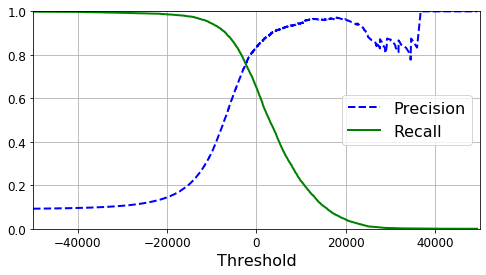

In [27]:
# Plot both precision and recall for the thresholds using matplotlib
# Select the threshold value that gives the best precision/ recall tradeoff to the task at hand.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])           

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Build model with 90% Precison

In [28]:
# Let's say you decide to aim for 90% precision. You need to look for threshold which will give 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
# Get the predicted values with threshold which gives 90% precision

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
# Calculate precision score

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
# Calculate recall score

recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

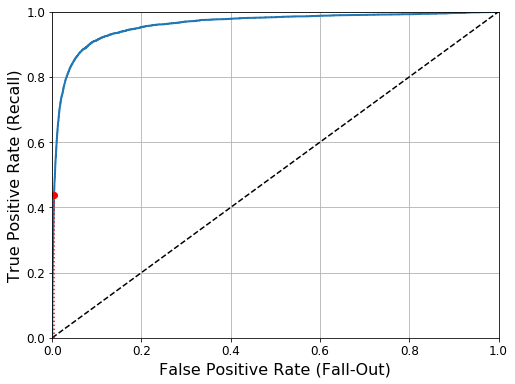

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                        
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

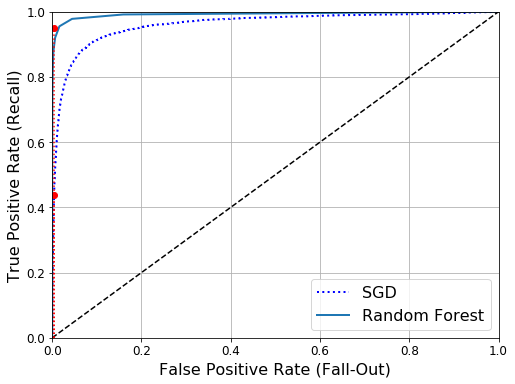

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.986046511627907

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889

# Multiclass classification

In [41]:
# Mutliclass Classification Using SGD Classifier

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [42]:
# Check accuracy using Cross Validation

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [43]:
# Improving accuracy by scaling the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/abhinav/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

# Multilabel classification

In [44]:
# Multilabel classifier to classify image in two labels
# Label 1 - if it is greater than 7 
# Label 2 - if it is odd

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)


y_multilabel = np.c_[y_train_large, y_train_odd]

In [45]:
# Train the model using KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [46]:
# Test the classifier

knn_clf.predict([some_digit])

array([[False,  True]])

# Multioutput classification

In [47]:
# Adding noise in training set

import numpy.random as rnd

noise_train = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train


# Adding noise in test set

noise_test = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test

# Setting clean image as the label (y_train and y_test)

y_train_mod = X_train
y_test_mod = X_test

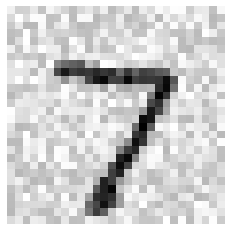

In [48]:
# View the noisy image

some_index = 0
plot_digit(X_test_mod[some_index])

**Warning**: the next cell may take hours to run, depending on your hardware.

In [49]:
# Let us clean the image using the Classifier

knn_clf.fit(X_train_mod, y_train_mod)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

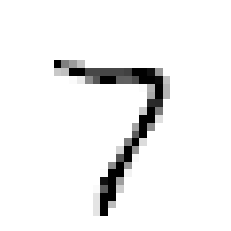

In [50]:
# View cleaned image

clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)